# Paclitaxel ALL Samples

In [ ]:
# Set the working directory to the location of CYTOi EMC data files
source('../../functions.R') 
setwd('../../CYTOi/Paclitaxel/Expression_Mutation_CNA')

In [21]:
getwd()

[1] "d:/MultiDrug_Final/CYTOi/Paclitaxel/Expression_Mutation_CNA"

In [ ]:
#dir.create("Results", showWarnings = FALSE)
#dir.create('Graphs',showWarnings = FALSE)

In [22]:
#---------------------------------------------------------------------------------------------------------------
# Read sensitive CYTOi Paclitaxel EMC ALL sample and process expression, mutation, and CNA data

# Function to process TSV files for consistency
# process_tsv_files('TCGA - EC CYTOi Paclitaxel Resistant BRCA Samples CNA.tsv','TCGA - EC CYTOi Paclitaxel Resistant BRCA Samples Gene Expression.tsv')

# Define a conversion table for gene symbol changes
conversion_table <- data.frame(
        Old.Symbol = c("CCN1", "DSC3", "CELSR1", "DSP", "RIN2", "TCF4"),
        Converted.Symbol = c("PPP3CA", "DSC2", "ME2", "DSPP", "RASSF4", "TCF7L2")
)

# Process drug data for sensitive and resistant samples
CYTOi_Paclitaxel_ALL = process_drug_data(
        expr_sensitive_file = 'TCGA - EMC CYTOi Paclitaxel Sensitive Samples Gene Expression.tsv',
        cna_sensitive_file = 'TCGA - EMC CYTOi Paclitaxel Sensitive Samples CNA.tsv',
        expr_resistant_file = 'TCGA - EMC CYTOi Paclitaxel Resistant Samples Gene Expression.tsv',
        cna_resistant_file = 'TCGA - EMC CYTOi Paclitaxel Resistant Samples CNA.tsv',
        mut_sensitive_file = 'TCGA - EMC CYTOi Paclitaxel Sensitive Samples Mutation.tsv',
        mut_resistant_file = 'TCGA - EMC CYTOi Paclitaxel Resistant Samples Mutation.tsv',
        conversion_table = conversion_table
)

# Set condition factor levels for consistent modeling
CYTOi_Paclitaxel_ALL$condition = factor(CYTOi_Paclitaxel_ALL$condition, levels = c('resistant','sensitive'))

# Fetch clinical data for multiple TCGA projects
CYTOi_ALL_Clinical = get_multiple_clinical_data(tcga_project = c('TCGA-BRCA', 'TCGA-HNSC', 'TCGA-STAD', 'TCGA-LUAD', 'TCGA-UCS'))

# Check overlap between sample IDs in processed data and clinical data
sum(rownames(CYTOi_Paclitaxel_ALL) %in% CYTOi_ALL_Clinical$submitter_id) # 35 matches found

# Filter clinical data to retain only matching samples
CYTOi_ALL_Clinical_Paclitaxel = CYTOi_ALL_Clinical %>% filter(submitter_id %in% rownames(CYTOi_Paclitaxel_ALL))

new_row_indices <- match(rownames(CYTOi_Paclitaxel_ALL), CYTOi_ALL_Clinical_Paclitaxel$submitter_id)
CYTOi_ALL_Clinical_Paclitaxel <- CYTOi_ALL_Clinical_Paclitaxel[new_row_indices, ]

# Create a survival object using clinical data
CYTOi_ALL_Paclitaxel_Surv = Surv(time = CYTOi_ALL_Clinical_Paclitaxel$overall_survival, event = CYTOi_ALL_Clinical_Paclitaxel$deceased)
#saveRDS(CYTOi_ALL_Paclitaxel_Surv, 'Results/CYTOi_ALL_Paclitaxel_Surv.rds')


[1] 35

### Note on Computation Time
The calculation steps for the Penalized Cox Models and the subsequent Multi-Gene Cox Models are computationally intensive and can take a significant amount of time to run.

For your convenience, you can skip re-running these analyses. The code block below allows you to directly load the pre-computed results (.rds files) to proceed with the analysis and visualization steps immediately

In [ ]:
#---------------------------------------------------------------------------------------------------------------
# Penalized Cox Regression Analysis

# Run penalized Cox regression models for the processed data
CYTOi_EMC_ALL_Paclitaxel_Pen_CoxModel = drug_small_sample_models_cond_penalized_with_pvalue_optimized(
        data = CYTOi_Paclitaxel_ALL,
        surv_obj = CYTOi_ALL_Paclitaxel_Surv,
        seed = 73
)

# Load enriched terms for pathway analysis
enrich_terms = read_excel('enriched_terms.xlsx')

# Extract unique genes from enriched terms
gen_list <- extract_unique_genes(enrich_terms)

# Process the penalized Cox models with the gene list
CYTOi_EMC_ALL_Paclitaxel_Pen_CoxModel <- process_models(CYTOi_EMC_ALL_Paclitaxel_Pen_CoxModel, gen_list)

# Save the processed Cox models
#saveRDS(CYTOi_EMC_ALL_Paclitaxel_Pen_CoxModel, 'Results/CYTOi_EMC_ALL_Paclitaxel_Pen_CoxModel.rds')

In [ ]:
#---------------------------------------------------------------------------------------------------------------
# Multi-gene Cox Models

# Run multi-gene Cox models without combination terms
multiGeneCox_CYTOi_ALL = drug_multigene_models_cond_penalized(
        CYTOi_Paclitaxel_ALL,
        CYTOi_ALL_Paclitaxel_Surv,
        pathway_file = 'enriched_terms.xlsx',
        CYTOi_EMC_ALL_Paclitaxel_Pen_CoxModel,
        combination = F,
        seed = 73
)

# Save multi-gene Cox model results
#saveRDS(multiGeneCox_CYTOi_ALL, 'Results/CYTOi_EMC_ALL_Paclitaxel_MultiGeneCox.rds')

### Load Pre-Computed Results

To skip the lengthy model computation steps, simply run the following code block. This will load the pre-calculated models (`CYTOi_EMC_ALL_Paclitaxel_Pen_CoxModel` and `multiGeneCox_CYTOi_ALL`) directly from their saved `.rds` files.

In [3]:
CYTOi_EMC_ALL_Paclitaxel_Pen_CoxModel = readRDS('Results/CYTOi_EMC_ALL_Paclitaxel_Pen_CoxModel.rds')
multiGeneCox_CYTOi_ALL = readRDS('Results/CYTOi_EMC_ALL_Paclitaxel_MultiGeneCox.rds') 

New names:
• `` -> `...2`
• `` -> `...3`
• `` -> `...4`
• `` -> `...5`
• `` -> `...6`
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`


Processing Model_1 
Filtered gene list for Model_1 : FYN, MYL9, FLNB 
Processing Model_2 
Filtered gene list for Model_2 : FLNB 
Not enough genes for combinations in Model_2 . Only single genes will be used.


Warning message in geom_bar(stat = "identity", width = 0.7, color = "black", size = 0.2):
"Ignoring unknown parameters: `size`"
Warning message:
"The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead."
New names:
• `` -> `...2`
• `` -> `...3`
• `` -> `...4`
• `` -> `...5`
• `` -> `...6`
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`


Processing Model_1 
Filtered gene list for Model_1 : TCF7L2, FYN 
Processing Model_2 
No valid genes for Model_2 . Skipping...


Warning message in geom_bar(stat = "identity", width = 0.7, color = "black", size = 0.2):
"Ignoring unknown parameters: `size`"


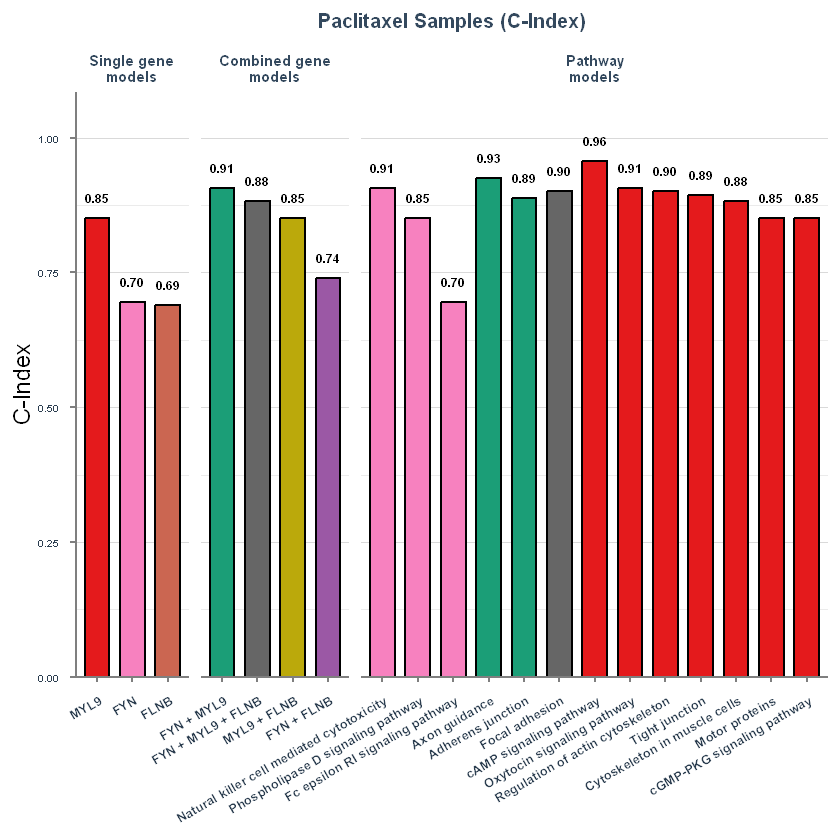

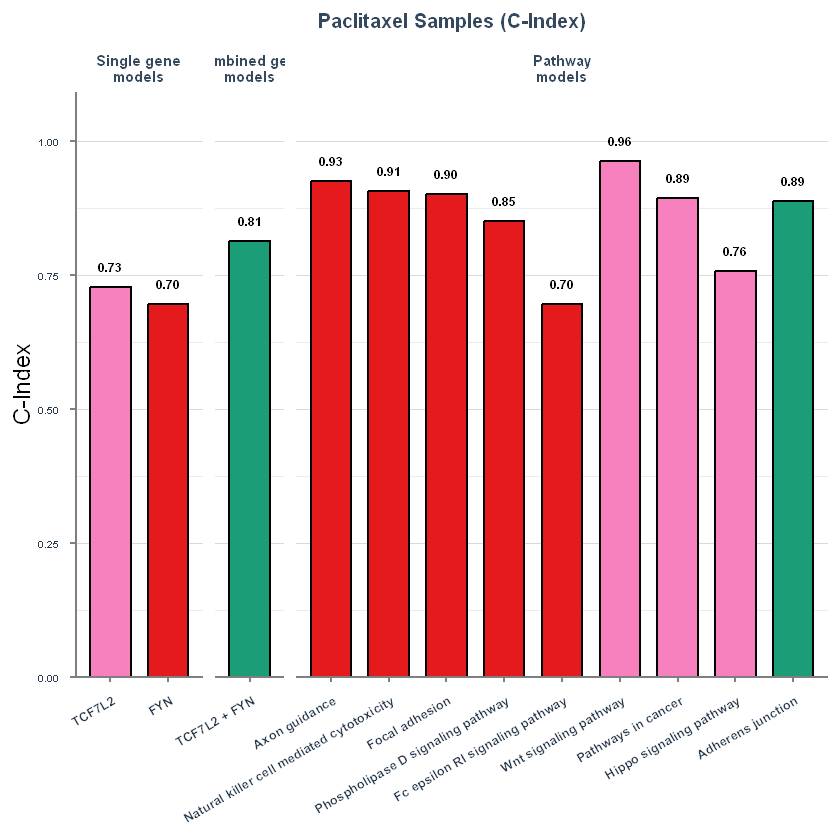

In [4]:
#---------------------------------------------------------------------------------------------------------------
# Analyze Specific Genes and Pathways

# Analyze specific genes and pathways using a predefined list
results_FYN_MYL9_FLNB <- analyze_genes_and_pathways_for_models(
        gene_list = c("FYN", "MYL9", "FLNB"),
        excluded_pathways = c("Pathogenic Escherichia coli infection", 'Salmonella infection', 'Viral myocarditis', 'Shigellosis'),
        processed_data = CYTOi_Paclitaxel_ALL,
        surv_obj = CYTOi_ALL_Paclitaxel_Surv,
        single_gene_model = CYTOi_EMC_ALL_Paclitaxel_Pen_CoxModel,
        multi_cox_model = multiGeneCox_CYTOi_ALL,
        enrichment_table_path = "enriched_terms.xlsx"
)

# Generate barplot for analyzed models
model1_results = results_FYN_MYL9_FLNB$Model1
plot_model1_FYN_MYL9_FLNB <- cindex_barplot_vertical_v5_improved(
        model1_results,
        "Model_1",
        'Paclitaxel Samples (C-Index)'
)
plot_model1_FYN_MYL9_FLNB
# Save barplot
#saveRDS(plot_model1_FYN_MYL9_FLNB, 'Graphs/FYN_MYL9_FLNB_CYTOiPaclitaxel_ALL_C_index.rds')


#TCF
# Analyze specific genes and pathways using a predefined list
results_TCF7L2_FYN <- analyze_genes_and_pathways_for_models(
  gene_list = c("TCF7L2", "FYN"),
  excluded_pathways = c("Pathogenic Escherichia coli infection", 'Salmonella infection', 'Viral myocarditis', 'Shigellosis','Prostate cancer','Endometrial cancer','Gastric cancer','Cushing syndrome','Breast cancer','Hepatocellular carcinoma','Colorectal cancer','Human cytomegalovirus infection','Arrhythmogenic right ventricular cardiomyopathy','Melanogenesis','Thyroid cancer','Basal cell carcinoma','Acute myeloid leukemia','Human papillomavirus infection'),
  processed_data = CYTOi_Paclitaxel_ALL,
  surv_obj = CYTOi_ALL_Paclitaxel_Surv,
  single_gene_model = CYTOi_EMC_ALL_Paclitaxel_Pen_CoxModel,
  multi_cox_model = multiGeneCox_CYTOi_ALL,
  enrichment_table_path = "enriched_terms.xlsx"
)

# Generate barplot for analyzed models
model1_results_tcf = results_TCF7L2_FYN$Model1
plot_model1_TCF7L2_FYN <- cindex_barplot_vertical_v5_improved(
  model1_results_tcf,
  "Model_1",
  'Paclitaxel Samples (C-Index)'
)
plot_model1_TCF7L2_FYN
# Save barplot
#saveRDS(plot_model1_TCF7L2_FYN, 'Graphs/TCF7L2_FYN_CYTOiPaclitaxel_ALL_C_index.rds')

Processing genes for cna 
Filtered gene list for cna : TCF7L2, LDHB 
Calculating all intermediate combinations (combinations = 'all')...


Warning message in geom_bar(stat = "identity", width = 0.7, color = "black", size = 0.2):
"Ignoring unknown parameters: `size`"


$CNA

$Mutation
NULL


Processing genes for cna 
Filtered gene list for cna : TCF7L2, FYN 
Calculating all intermediate combinations (combinations = 'all')...


Warning message in geom_bar(stat = "identity", width = 0.7, color = "black", size = 0.2):
"Ignoring unknown parameters: `size`"


$CNA

$Mutation
NULL


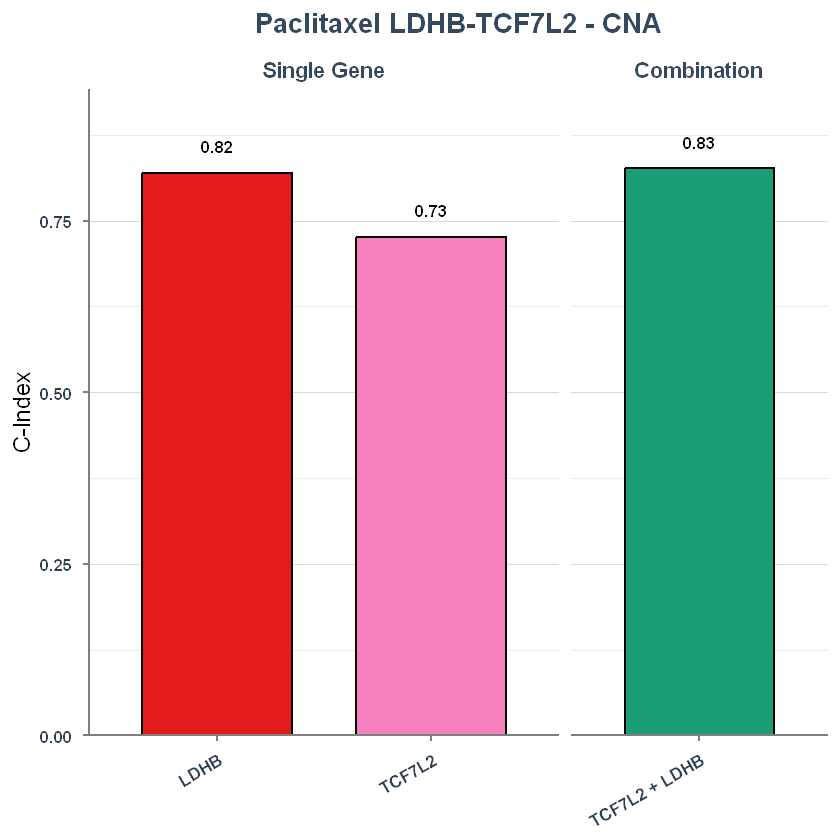

Processing genes for cna 
Filtered gene list for cna : CXCR4, FYN 
Calculating all intermediate combinations (combinations = 'all')...


Warning message in geom_bar(stat = "identity", width = 0.7, color = "black", size = 0.2):
"Ignoring unknown parameters: `size`"


$CNA

$Mutation
NULL


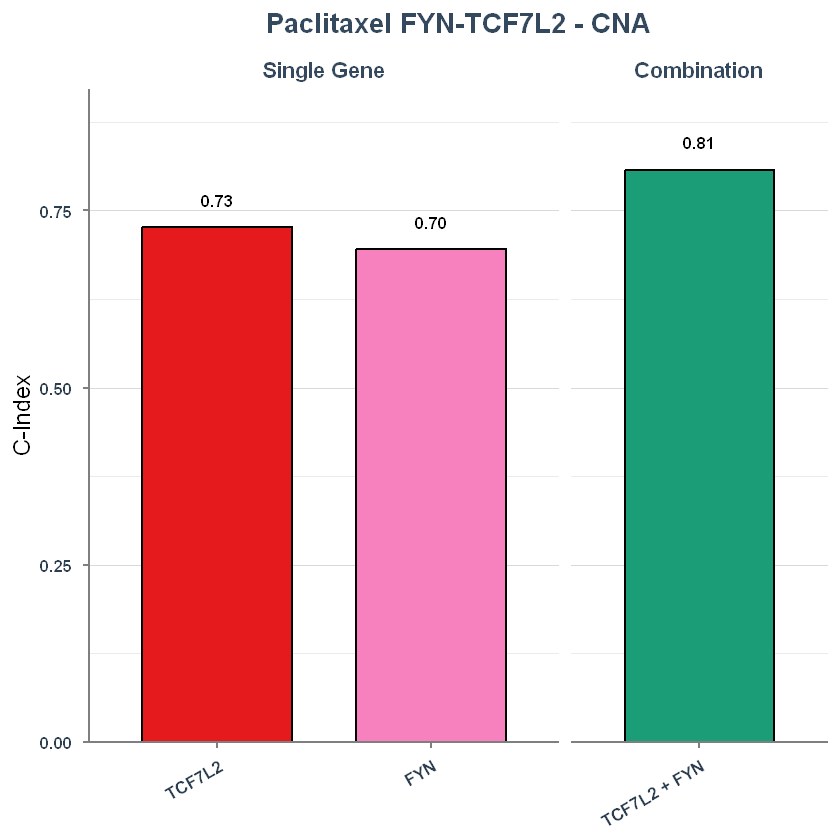

Processing genes for cna 
Filtered gene list for cna : CXCR4, FYN, TCF7L2 
Calculating only the full combination (combinations = 'singles_and_full')...


Warning message in geom_bar(stat = "identity", width = 0.7, color = "black", size = 0.2):
"Ignoring unknown parameters: `size`"


$CNA

$Mutation
NULL


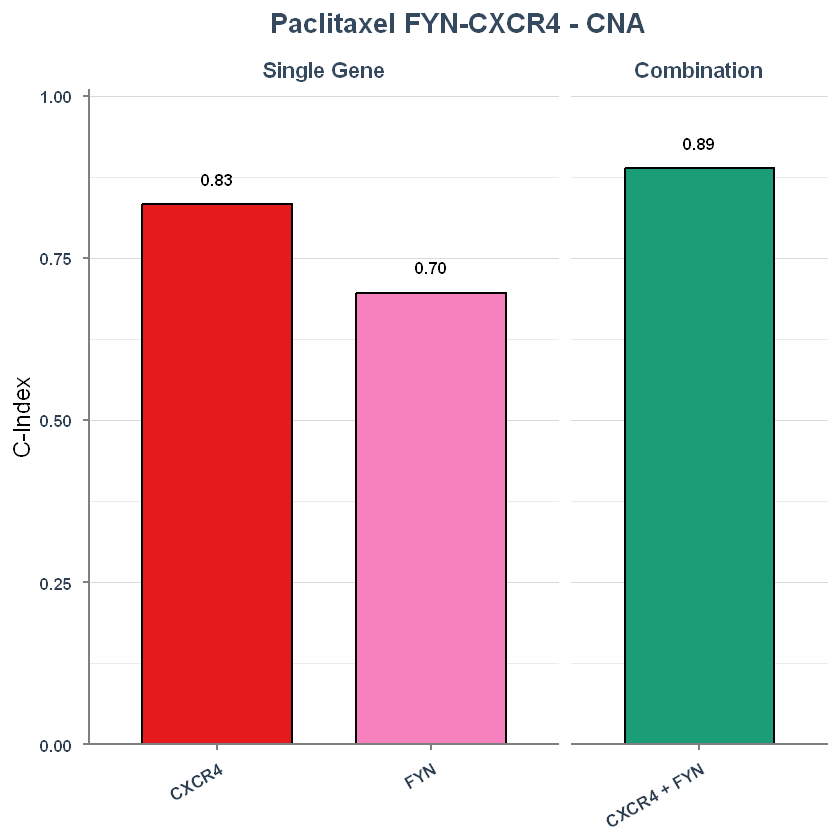

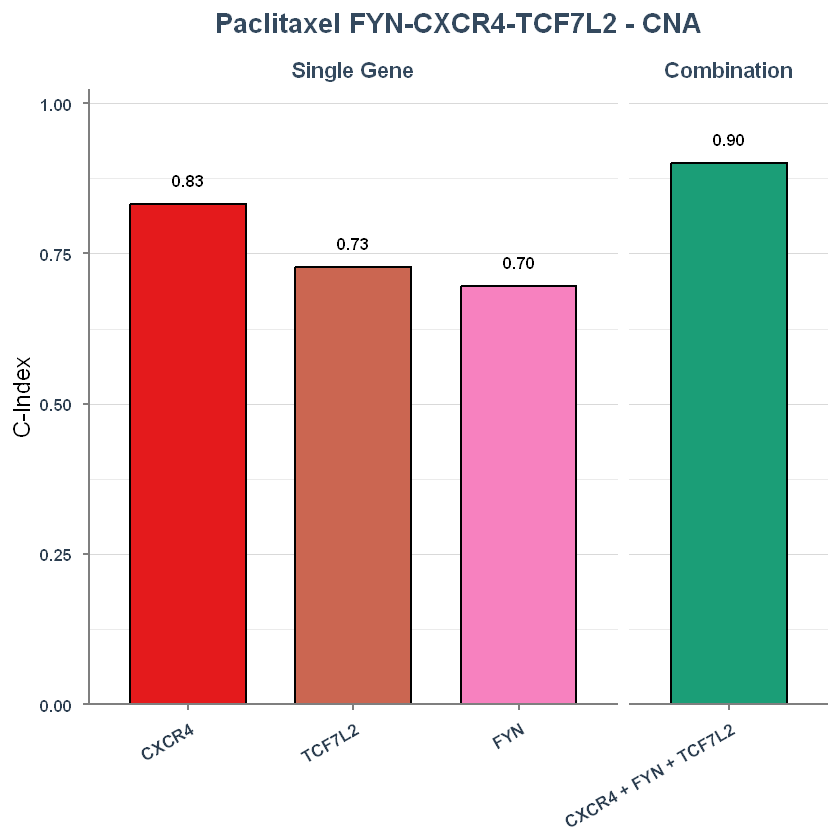

In [10]:
#---------------------------------------------------------------------------------------------------------------
# Additional Analysis for Gene Combinations and HRs

# Analyze combinations of specific genes
results_TCF7L2_LDHB = analyze_genes_for_combinations(
        gene_list = c('TCF7L2', 'LDHB'),
        processed_data = CYTOi_Paclitaxel_ALL,
        surv_obj = CYTOi_ALL_Paclitaxel_Surv,
        single_gene_model = CYTOi_EMC_ALL_Paclitaxel_Pen_CoxModel,
        seed=73
)

# Plot results for gene combinations
results_TCF7L2_LDHB_plot = plot_cindex_results_separate(
        results_TCF7L2_LDHB,
        'Paclitaxel LDHB-TCF7L2'
)
results_TCF7L2_LDHB_plot
# Save CNA plot
#saveRDS(results_FYN_LDHB_plot$CNA, 'Graphs/TCF7L2_LDHB_Paclitaxel_ALL_C-index.rds')

#-------
# Analyze combinations of specific genes
results_TCF7L2_FYN = analyze_genes_for_combinations(
  gene_list = c('TCF7L2', 'FYN'),
  processed_data = CYTOi_Paclitaxel_ALL,
  surv_obj = CYTOi_ALL_Paclitaxel_Surv,
  single_gene_model = CYTOi_EMC_ALL_Paclitaxel_Pen_CoxModel,
  seed=73
)

# Plot results for gene combinations
results_TCF7L2_FYN_plot = plot_cindex_results_separate(
  results_TCF7L2_FYN,
  'Paclitaxel FYN-TCF7L2'
)
results_TCF7L2_FYN_plot
# Save CNA plot
#saveRDS(results_TCF7L2_FYN_plot$CNA, 'Graphs/TCF7L2_FYN_Paclitaxel_ALL_C-index.rds')
#-------

# Analyze combinations of specific genes
results_CXCR4_FYN = analyze_genes_for_combinations(
  gene_list = c('CXCR4', 'FYN'),
  processed_data = CYTOi_Paclitaxel_ALL,
  surv_obj = CYTOi_ALL_Paclitaxel_Surv,
  single_gene_model = CYTOi_EMC_ALL_Paclitaxel_Pen_CoxModel,
  seed=73
)

# Plot results for gene combinations
results_CXCR4_FYN_plot = plot_cindex_results_separate(
  results_CXCR4_FYN,
  'Paclitaxel FYN-CXCR4'
)
results_CXCR4_FYN_plot
# Save CNA plot
#saveRDS(results_CXCR4_FYN_plot$CNA, 'Graphs/CXCR4_FYN_Paclitaxel_ALL_C-index.rds')

#-------

# Analyze combinations of specific genes
results_CXCR4_FYN_TCF7L2 = analyze_genes_for_combinations(
  gene_list = c('CXCR4', 'FYN', 'TCF7L2'),
  processed_data = CYTOi_Paclitaxel_ALL,
  surv_obj = CYTOi_ALL_Paclitaxel_Surv,
  single_gene_model = CYTOi_EMC_ALL_Paclitaxel_Pen_CoxModel,
  seed=73,
  combinations = 'singles_and_full'
  
)

# Plot results for gene combinations
results_CXCR4_FYN_TCF7L2_plot = plot_cindex_results_separate(
  results_CXCR4_FYN_TCF7L2,
  'Paclitaxel FYN-CXCR4-TCF7L2'
)
results_CXCR4_FYN_TCF7L2_plot
# Save CNA plot
#saveRDS(results_CXCR4_FYN_TCF7L2_plot$CNA, 'Graphs/CXCR4_FYN_TCF7L2_Paclitaxel_ALL_C_index.rds')


Processing single gene model for: LDHB 
Processing single gene model for: TCF7L2 
Calculating all intermediate combinations (combinations = 'all')...
Processing combination model for: LDHB + TCF7L2 


Warning message in geom_bar(stat = "identity", width = 0.7, color = "black", size = 0.2):
"Ignoring unknown parameters: `size`"


Processing single gene model for: FYN 
Processing single gene model for: TCF7L2 
Calculating all intermediate combinations (combinations = 'all')...
Processing combination model for: FYN + TCF7L2 


Warning message in geom_bar(stat = "identity", width = 0.7, color = "black", size = 0.2):
"Ignoring unknown parameters: `size`"


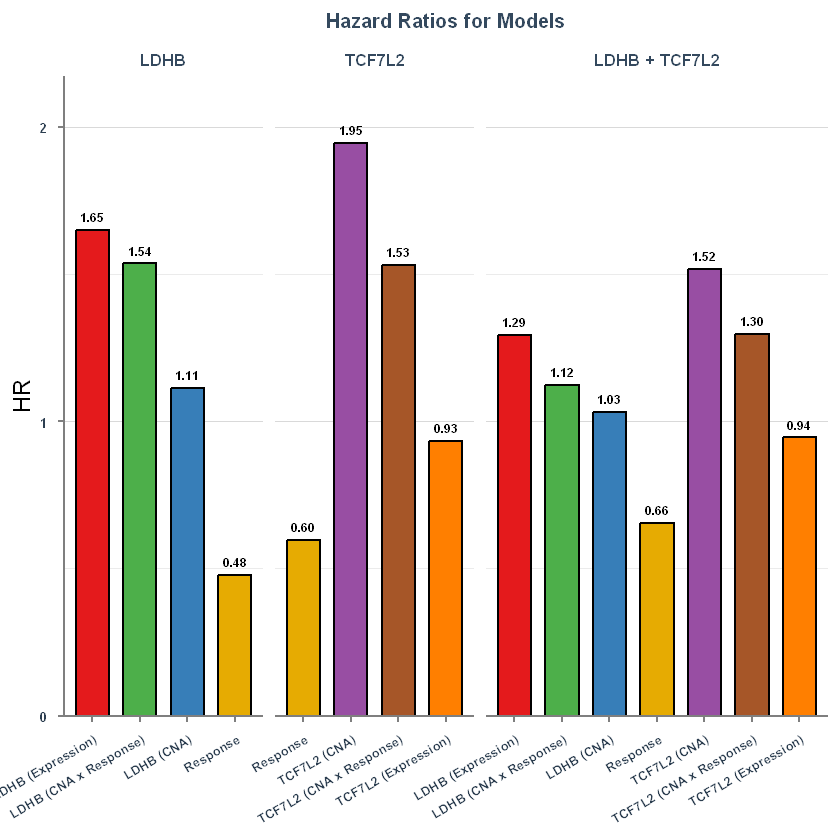

Processing single gene model for: FYN 
Processing single gene model for: CXCR4 
Calculating all intermediate combinations (combinations = 'all')...
Processing combination model for: FYN + CXCR4 


Warning message in geom_bar(stat = "identity", width = 0.7, color = "black", size = 0.2):
"Ignoring unknown parameters: `size`"


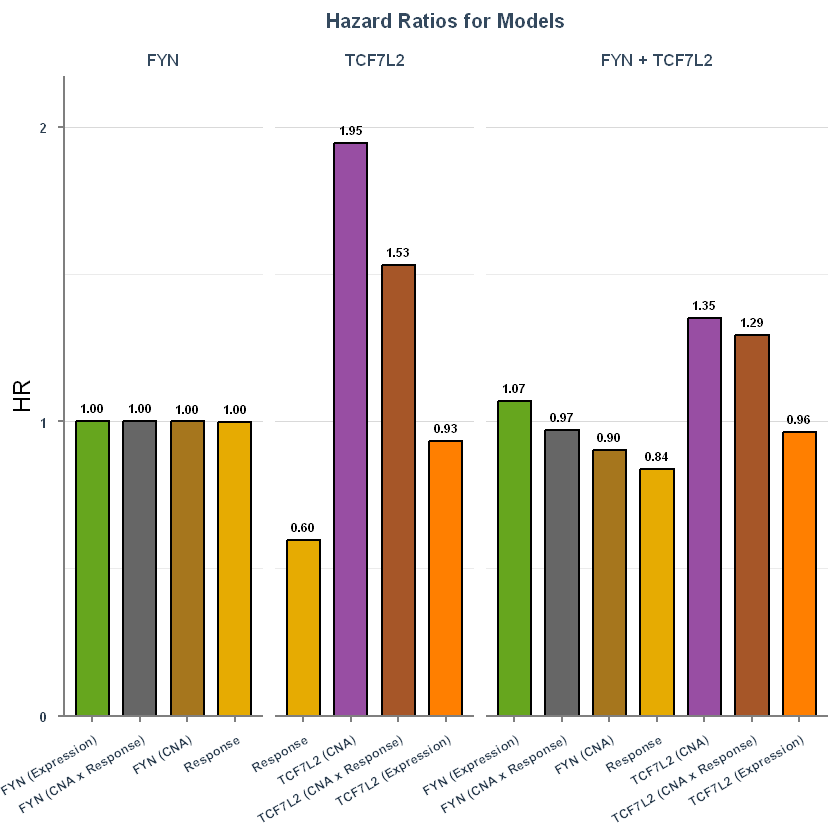

Processing single gene model for: FYN 
Processing single gene model for: CXCR4 
Processing single gene model for: TCF7L2 
Calculating only the full combination (combinations = 'singles_and_full')...
Processing full combination model for: FYN + CXCR4 + TCF7L2 


Warning message in geom_bar(stat = "identity", width = 0.7, color = "black", size = 0.2):
"Ignoring unknown parameters: `size`"


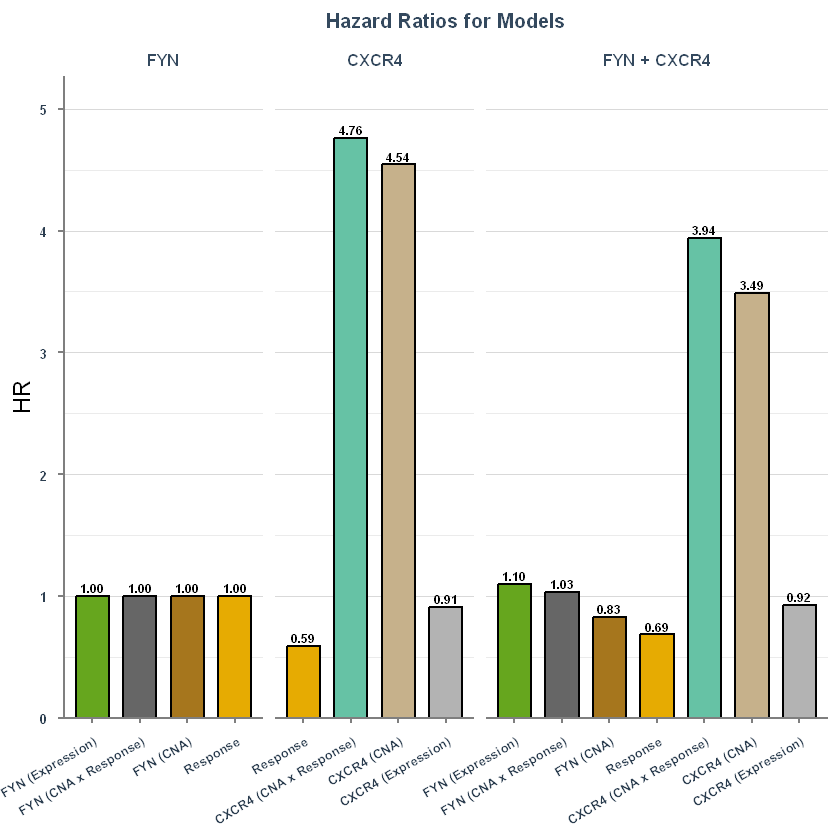

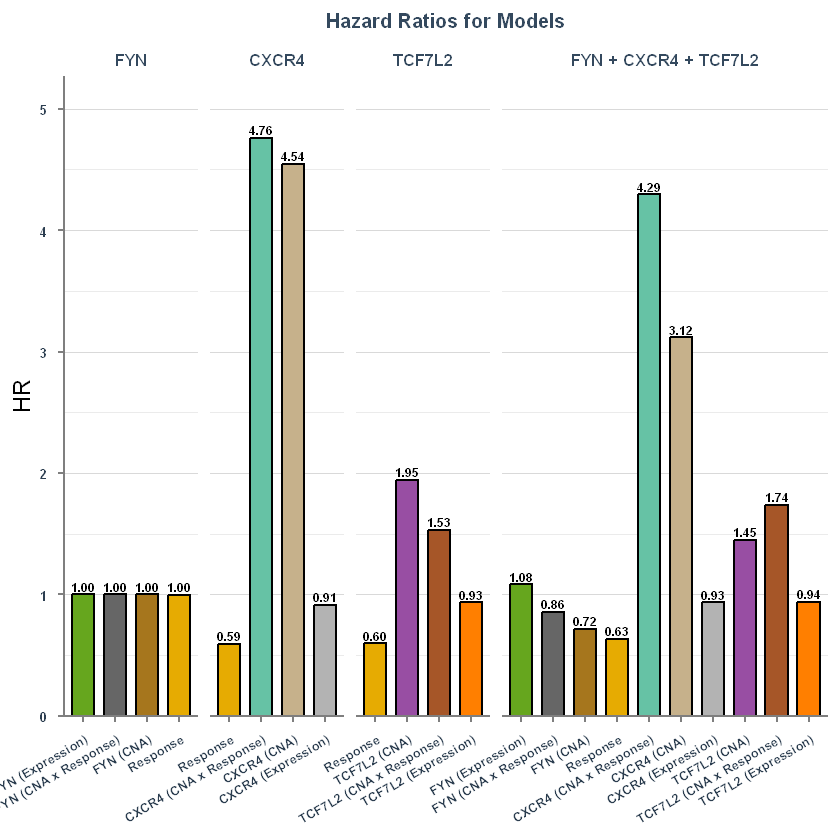

In [7]:
#---------------------------------------------------------------------------------------------------------------
# Hazard Ratio Analysis

# Perform HR analysis for specific genes
A = analyze_genes_with_hr(
        gene_list = c('LDHB', 'TCF7L2'),
        processed_data = CYTOi_Paclitaxel_ALL,
        surv_obj = CYTOi_ALL_Paclitaxel_Surv,
        seed=73
)

# Format terms for visualization
A$Term = format_terms(A$Term)

# Plot HR bar chart
LDHB_TCF_HR = plot_hr_bar(A)
LDHB_TCF_HR
# Save HR bar chart
#saveRDS(LDHB_TCF_HR, 'Graphs/LDHB_TCF_HR.rds')

#-------


# Perform HR analysis for specific genes
A = analyze_genes_with_hr(
  gene_list = c('FYN', 'TCF7L2'),
  processed_data = CYTOi_Paclitaxel_ALL,
  surv_obj = CYTOi_ALL_Paclitaxel_Surv,
  seed=73
)

# Format terms for visualization
A$Term = format_terms(A$Term)

# Plot HR bar chart
FYN_TCF_HR = plot_hr_bar(A)
FYN_TCF_HR
# Save HR bar chart
#saveRDS(FYN_TCF_HR, 'Graphs/FYN_TCF_HR.rds')

#-------


# Perform HR analysis for specific genes
A = analyze_genes_with_hr(
  gene_list = c('FYN', 'CXCR4'),
  processed_data = CYTOi_Paclitaxel_ALL,
  surv_obj = CYTOi_ALL_Paclitaxel_Surv,
  seed=73
)

# Format terms for visualization
A$Term = format_terms(A$Term)

# Plot HR bar chart
FYN_CXCR4_HR = plot_hr_bar(A)
FYN_CXCR4_HR
# Save HR bar chart
#saveRDS(FYN_CXCR4_HR, 'Graphs/FYN_CXCR4_HR.rds')

#----------

# Perform HR analysis for specific genes
A = analyze_genes_with_hr(
  gene_list = c('FYN', 'CXCR4', 'TCF7L2'),
  processed_data = CYTOi_Paclitaxel_ALL,
  surv_obj = CYTOi_ALL_Paclitaxel_Surv,
  seed=73,
  combinations = 'singles_and_full'
)

# Format terms for visualization
A$Term = format_terms(A$Term)

# Plot HR bar chart
FYN_CXCR4_TCF7L2_HR = plot_hr_bar(A)

FYN_CXCR4_TCF7L2_HR
# Save HR bar chart
#saveRDS(FYN_CXCR4_TCF7L2_HR, 'Graphs/FYN_CXCR4_TCF7L2_HR.rds')


#------


In [ ]:
#synergistic pen cox models------------------------------

rename_generic_terms <- function(term_vec, GEN1, GEN2) {
  out <- term_vec
  # gene1
  out <- gsub(paste0("expr_", GEN1), "expr_gene1", out, fixed = TRUE)
  out <- gsub(paste0("factor(cna_", GEN1, ")1"), "factor(cna_gene1)1", out, fixed = TRUE)
  # gene2
  out <- gsub(paste0("expr_", GEN2), "expr_gene2", out, fixed = TRUE)
  out <- gsub(paste0("factor(cna_", GEN2, ")1"), "factor(cna_gene2)1", out, fixed = TRUE)
  out
}

rename_pretty_generic_terms <- function(term_vec_generic) {
  x <- term_vec_generic
  
  x <- gsub("^factor\\(condition\\)([^:]+)$",                  "HR CONDITION[\\1]", x)
  x <- gsub("^factor\\(cna_gene1\\)1:factor\\(condition\\)([^:]+)$",
            "HR CNA_GENE1 : CONDITION[\\1]", x)
  x <- gsub("^factor\\(cna_gene2\\)1:factor\\(condition\\)([^:]+)$",
            "HR CNA_GENE2 : CONDITION[\\1]", x)
  
  #main 
  x <- gsub("^expr_gene1$",                "HR EXP_GENE1", x)
  x <- gsub("^expr_gene2$",                "HR EXP_GENE2", x)
  x <- gsub("^factor\\(cna_gene1\\)1$",    "HR CNA_GENE1", x)
  x <- gsub("^factor\\(cna_gene2\\)1$",    "HR CNA_GENE2", x)
  
  # twoways interaction
  x <- gsub("^expr_gene1:expr_gene2$",                       "HR EXP_GENE1 : EXP_GENE2", x)
  x <- gsub("^expr_gene1:factor\\(cna_gene2\\)1$",           "HR EXP_GENE1 : CNA_GENE2", x)
  x <- gsub("^factor\\(cna_gene1\\)1:expr_gene2$",           "HR CNA_GENE1 : EXP_GENE2", x)
  x <- gsub("^factor\\(cna_gene1\\)1:factor\\(cna_gene2\\)1$","HR CNA_GENE1 : CNA_GENE2", x)
  x
}

# wide + generic + pretty 
two_way_glmnet_wide_generic_pretty <- function(
    GEN1, GEN2,
    data,                        
    surv,                       
    dataset_label   = "ALL",
    treatment_label = "Paclitaxel",
    alpha = 0,
    seed  = 73
){
  
  two_way_formula_str <- paste(
    "~ (",
    paste0("expr_", GEN1), "+", paste0("factor(cna_", GEN1, ")"),
    ") * (",
    paste0("expr_", GEN2), "+", paste0("factor(cna_", GEN2, ")"),
    ")",
    "+",
    "factor(condition)",
    "+",
    paste0("factor(cna_", GEN1, ")"), ":factor(condition)",
    "+",
    paste0("factor(cna_", GEN2, ")"), ":factor(condition)"
  )
  

  mm <- model.matrix(as.formula(two_way_formula_str), data = data)
  if ("(Intercept)" %in% colnames(mm)) mm <- mm[, -1, drop = FALSE]
  
  # CV-glmnet (cox)
  set.seed(seed)
  cv_fit <- cv.glmnet(mm, surv, family = "cox", alpha = alpha)
  best_lambda <- cv_fit$lambda.min
  
  # Coef & HR
  coef_mat <- as.matrix(coef(cv_fit, s = "lambda.min"))
  coef_df <- tibble(
    Term         = rownames(coef_mat),
    Coefficient  = as.numeric(coef_mat[, 1]),
    Hazard_Ratio = exp(Coefficient)
  )
  
  # C-index
  risk <- predict(cv_fit, newx = mm, s = best_lambda, type = "link")
  cindex <- tryCatch({
    concordance.index(x = as.numeric(risk), surv.time = surv[,1], surv.event = surv[,2])$c.index
  }, error = function(e) NA_real_)
  
 
  coef_df$Term_generic <- rename_generic_terms(coef_df$Term, GEN1, GEN2)
  coef_df$Term_pretty  <- rename_pretty_generic_terms(coef_df$Term_generic)
  
  # Wide
  wide_tbl <- coef_df %>%
    select(Term_pretty, Hazard_Ratio) %>%
    tidyr::pivot_wider(names_from = Term_pretty, values_from = Hazard_Ratio)
  
  # Meta
  wide_tbl <- wide_tbl %>%
    mutate(
      Dataset   = dataset_label,
      Treatment = treatment_label,
      Gene_Pair = paste(GEN1, "+", GEN2),
      C_Index   = round(cindex, 3),
      Lambda    = best_lambda,
      .before = 1
    )
  
  list(
    summary_wide_pretty = wide_tbl,
    coefficients_long   = coef_df,
    model               = cv_fit,
    lambda_min          = best_lambda
  )
}

out1 <- two_way_glmnet_wide_generic_pretty(
 GEN1 = "TCF7L2", GEN2 = "LDHB",
 data = CYTOi_Paclitaxel_ALL,
 surv = CYTOi_ALL_Paclitaxel_Surv
)
out2 <- two_way_glmnet_wide_generic_pretty(
 GEN1 = "TCF7L2", GEN2 = "FYN",
 data = CYTOi_Paclitaxel_ALL,
 surv = CYTOi_ALL_Paclitaxel_Surv
)
out3 <- two_way_glmnet_wide_generic_pretty(
 GEN1 = "FYN", GEN2 = "CXCR4",
 data = CYTOi_Paclitaxel_ALL,
 surv = CYTOi_ALL_Paclitaxel_Surv
)

combined_results <- bind_rows(out1$summary_wide_pretty, out2$summary_wide_pretty, out3$summary_wide_pretty)
combined_results


Dataset,Treatment,Gene_Pair,C_Index,Lambda,HR EXP_GENE1,HR CNA_GENE1,HR EXP_GENE2,HR CNA_GENE2,HR CONDITION[sensitive],HR EXP_GENE1 : EXP_GENE2,HR EXP_GENE1 : CNA_GENE2,HR CNA_GENE1 : EXP_GENE2,HR CNA_GENE1 : CNA_GENE2,HR CNA_GENE1 : CONDITION[sensitive],HR CNA_GENE2 : CONDITION[sensitive]
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ALL,Paclitaxel,TCF7L2 + LDHB,0.795,0.5894374,0.9591346,1.278453,1.1784229,1.0199174,0.7670825,1.0010576,0.9951319,1.0231455,1.124016,1.158952,1.0629705
ALL,Paclitaxel,TCF7L2 + FYN,0.801,6.1542916,0.9951024,1.049771,1.0104025,0.9875507,0.9761364,0.9999990,0.9989080,1.0080963,1.040774,1.044527,0.9977734
ALL,Paclitaxel,FYN + CXCR4,0.901,0.2868797,1.0666667,0.842929,0.9575755,2.1898627,0.7554281,0.9969841,1.0976634,0.9710957,2.507691,0.961644,2.5823574


In [ ]:
# Perform Kaplan-Meier analysis on filtered models
results <- kaplan_meier_analysis(
  model1_data = CYTOi_EMC_ALL_Paclitaxel_Pen_CoxModel$Model_1,
  model2_data = CYTOi_EMC_ALL_Paclitaxel_Pen_CoxModel$Model_2,
  surv_obj = CYTOi_ALL_Paclitaxel_Surv,
  processed_data = CYTOi_Paclitaxel_ALL,
  hr_threshold = 1.1,
  th_pval=0.05,
  plot = F,
  plot_title_prefix = 'Paclitaxel Samples'
)

# Save Kaplan-Meier analysis results
#saveRDS(results, 'CYTOi_EMC_ALL_Paclitaxel_KM.rds')

MYL9_KM = results$Model1$Plots$MYL9_Interaction_cna_condition_HR
SDC4_KM = results$Model1$Plots$SDC4_Interaction_cna_condition_HR
SULF2_KM = results$Model1$Plots$SULF2_Interaction_cna_condition_HR
CXCR4_KM = results$Model1$Plots$CXCR4_Interaction_cna_condition_HR
CXCR4_KM_CNA = results$Model1$Plots$CXCR4_CNA_HR

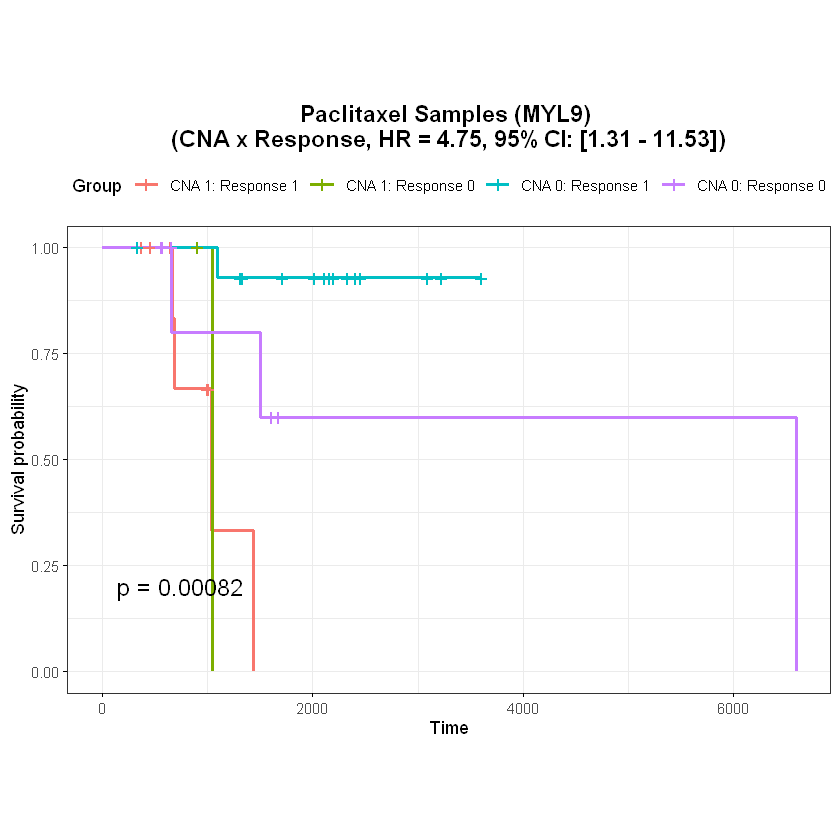

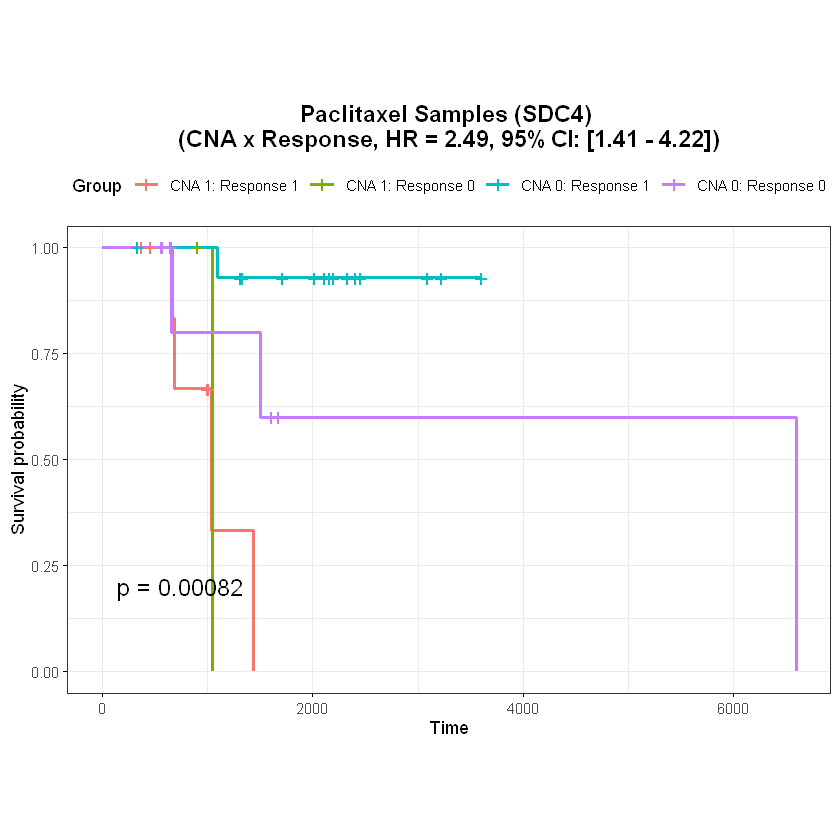

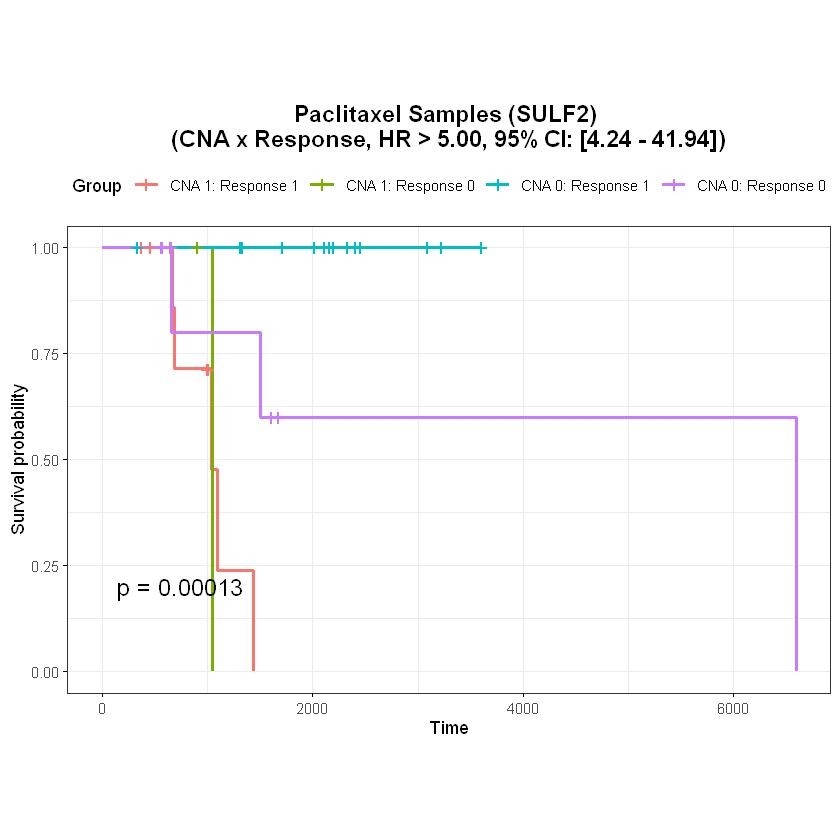

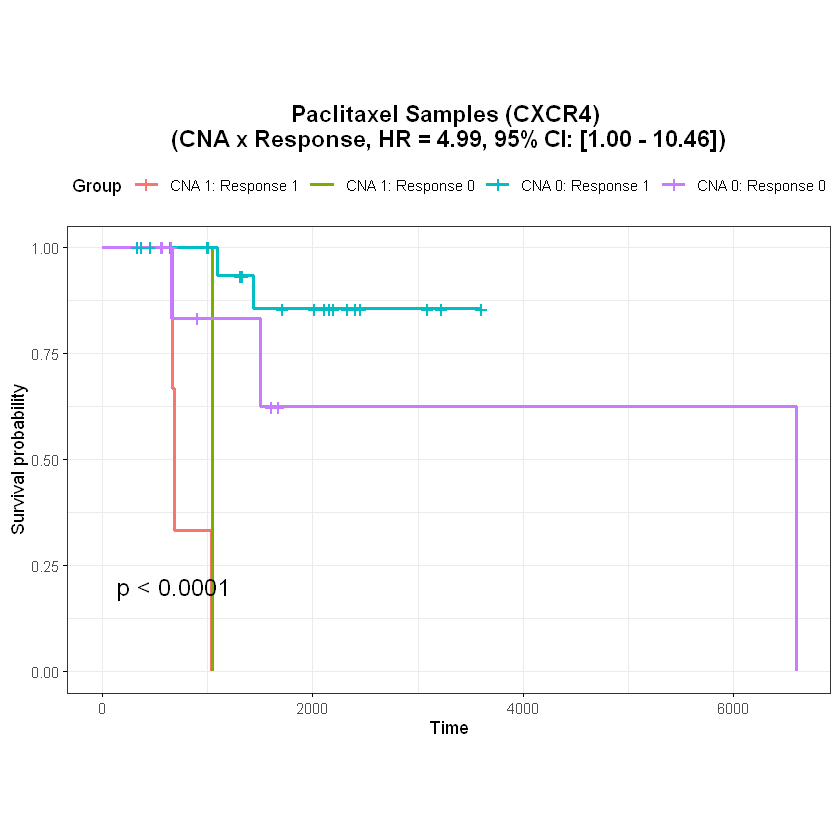

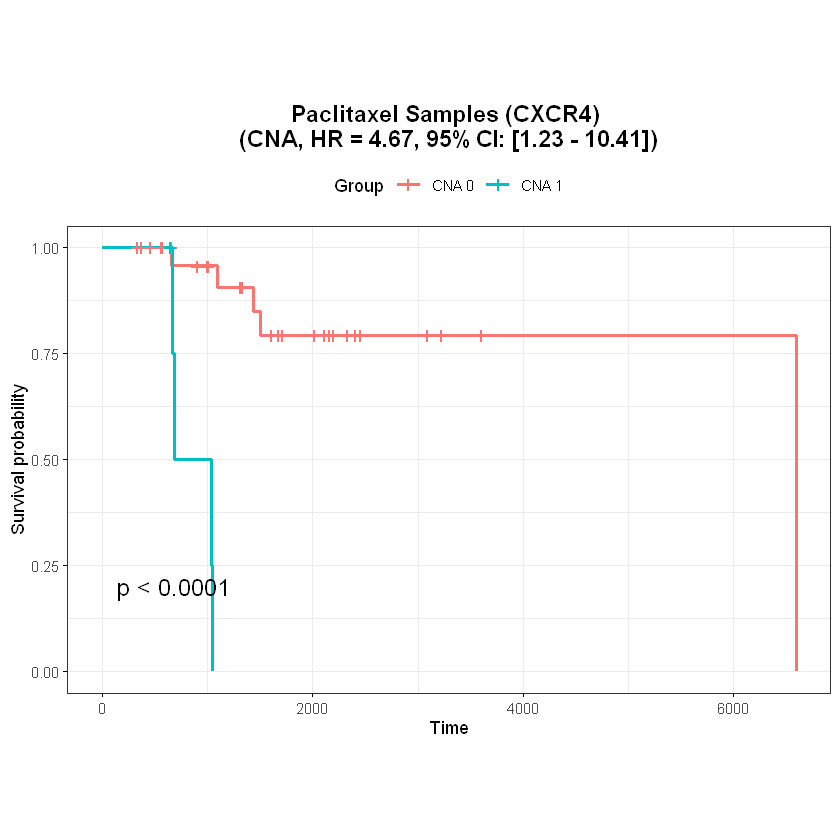

In [9]:
MYL9_KM
SDC4_KM
SULF2_KM
CXCR4_KM
CXCR4_KM_CNA